In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import graph_tool_extras as gte
import graph_tool.all as gt
from sklearn.preprocessing import StandardScaler

In [2]:
PATH = 'games-sales.csv'
data = pd.read_csv(PATH)

In [3]:
data.head(5)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [4]:
g = gte.load("degree.net.gz")
b, _ = gt.betweenness(g)
g.vp['betweenness'] = b

In [5]:
consoles = [v for v in g.vertices() if g.vp["Tipo"][v] == "Console"]
console_names = [g.vp["id"][v] for v in consoles]

# Removendo PC
index_pc = console_names.index("PC")
consoles_sem_pc = [v for i, v in enumerate(consoles) if i != index_pc]
console_names_sem_pc = [g.vp["id"][v] for v in consoles_sem_pc]

console_degrees = [g.get_total_degrees([v])[0] for v in consoles_sem_pc]
console_betweenness = [g.vp['betweenness'][v] for v in consoles_sem_pc]

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     47.52
Date:                Mon, 19 May 2025   Prob (F-statistic):           3.62e-14
Time:                        16:17:02   Log-Likelihood:                -506.26
No. Observations:                  80   AIC:                             1019.
Df Residuals:                      77   BIC:                             1026.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.4615     15.448      5.209      0.0

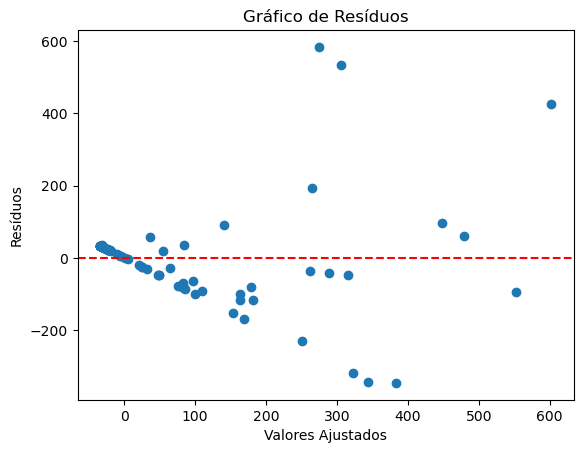

In [6]:
vendas_por_console_df = (
    data[data['console'].isin(console_names_sem_pc)]
    .groupby('console')['total_sales']
    .sum()
    .reset_index()
)

df_grafo = pd.DataFrame({
    "console": console_names_sem_pc,
    "degree": console_degrees,
    "betweenness": console_betweenness
})

df_merge = pd.merge(df_grafo, vendas_por_console_df, on="console")

# Define as variáveis independentes
X_raw = df_merge[["degree", "betweenness"]]

# Normaliza com StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Regressão linear: total_sales ~ degree + betweenness
X = sm.add_constant(X_scaled)
y = df_merge["total_sales"]
modelo = sm.OLS(y, X).fit()

print(modelo.summary())

# Gráfico de resíduos
plt.scatter(modelo.fittedvalues, modelo.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos")
plt.show()